In [1]:
import pathlib
import json
import numpy as np
import time
import matplotlib.pyplot as plt


def plot_matrix(mean_matrix, stddv_matrix, x_labels, y_labels, save_path, x_title='', y_title='', colour_map=plt.cm.OrRd):
    fig, ax = plt.subplots(figsize=(9,8))
    ax.set_xlabel(x_title, labelpad=20)
    ax.set_ylabel(y_title)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_xticks(range(len(x_labels)))
    ax.set_yticks(range(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    ax.imshow(mean_matrix, cmap=colour_map)

    for i in range(len(mean_matrix)):
        for j in range(len(mean_matrix[0])):
            mean = mean_matrix[i, j]
            std =  stddv_matrix[i, j]
            ax.text(j, i, f"{mean:.2f}\n{std:.2f}", va='center', ha='center')
    if save_path:
        fig.savefig(save_path)



In [2]:
def load_head_data(experiments_path):
    head_data = {}
    for task_dir in experiments_path.iterdir():
        head_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            head_mask = np.load(seed_dir / "head_mask.npy")
            head_data[task_dir.stem][seed_dir.stem] = {
                "head_mask": head_mask,
            }
    return head_data
def load_mlp_data(experiments_path):
    mlp_data = {}
    for task_dir in experiments_path.iterdir():
        mlp_data[task_dir.stem] = {}
        for seed_dir in task_dir.iterdir():
            mlp_mask = np.load(seed_dir / "mlp_mask.npy")
            mlp_importance = np.load(seed_dir / "mlp_importance.npy")
            mlp_data[task_dir.stem][seed_dir.stem] = {
                "mlp_mask": mlp_mask,
                "mlp_importance": mlp_importance
            }
    return mlp_data


In [3]:

experiments_path = pathlib.Path("../masks_results")
head_data = load_head_data(experiments_path)

experiments_path = pathlib.Path("../mlp_masks_results")
mlp_data = load_mlp_data(experiments_path)

experiments_path = pathlib.Path("../head_mlp_masks_results")
n_head_data = load_head_data(experiments_path)

experiments_path = pathlib.Path("../head_mlp_masks_results")
n_mlp_data = load_mlp_data(experiments_path)

# Task wise overlap % of pruned masks for each seed

In [4]:
def task_overlap_attention_heads(head_data, save_name):
    tasks = sorted(list(head_data.keys()))
    seeds = head_data["MNLI"].keys()
    results = np.zeros((len(seeds), len(tasks), len(tasks)))
    for seed_idx, seed in enumerate(seeds):
        for task_1_idx, task_1 in enumerate(tasks):
            for task_2_idx, task_2 in enumerate(tasks):
                common_heads = np.sum(head_data[task_1][seed]["head_mask"] * head_data[task_2][seed]["head_mask"])
                results[seed_idx][task_1_idx][task_2_idx] = common_heads
                
    mean_shared_heads = np.mean(results, axis=0)
    std_shared_heads = np.std(results, axis=0, ddof=1)
    plot_matrix(mean_shared_heads, std_shared_heads, tasks, tasks, save_name, "Task", "Task", plt.cm.Purples)

def task_overlap_mlps(mlp_data, save_name):
    tasks = sorted(list(mlp_data.keys()))
    seeds = mlp_data["MNLI"].keys()
    results = np.zeros((len(seeds), len(tasks), len(tasks)))
    for seed_idx, seed in enumerate(seeds):
        for task_1_idx, task_1 in enumerate(tasks):
            for task_2_idx, task_2 in enumerate(tasks):
                common_mlps = np.sum(mlp_data[task_1][seed]["mlp_mask"] * mlp_data[task_2][seed]["mlp_mask"])
                results[seed_idx][task_1_idx][task_2_idx] = common_mlps
                
    mean_shared_mlps = np.mean(results, axis=0)
    std_shared_mlps = np.std(results, axis=0, ddof=1)
    std_shared_mlps = np.std(results, axis=0, ddof=1)
    plot_matrix(mean_shared_mlps, std_shared_mlps, tasks, tasks, save_name, "Task", "Task", plt.cm.Purples)

## Task vs Task shared heads - Heads found separately

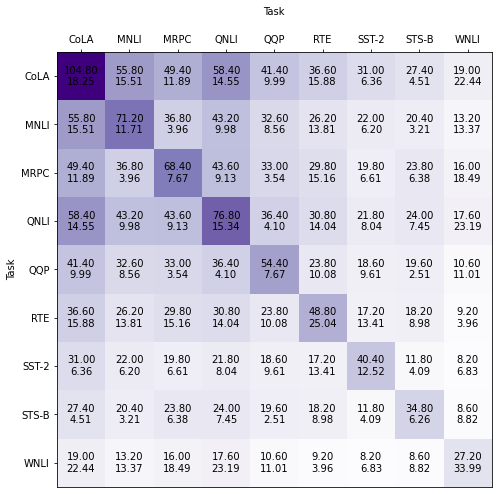

In [5]:
task_overlap_attention_heads(head_data, "common_components/task_v_task_heads_separate.pdf")

## Task vs Task shared heads - Heads found together with MLPs setting

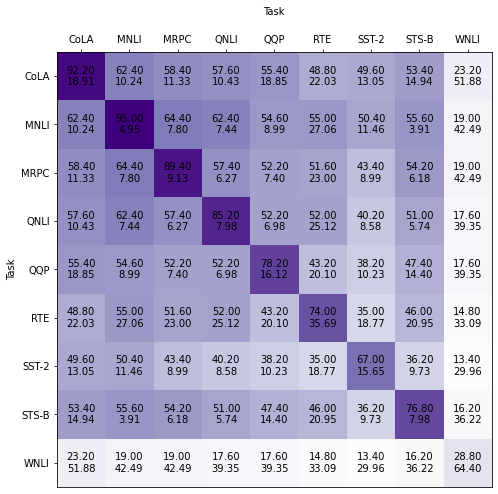

In [6]:

task_overlap_attention_heads(n_head_data, "common_components/task_v_task_heads_together.pdf")

## Task vs Task shared MLPs - MLPS found separate

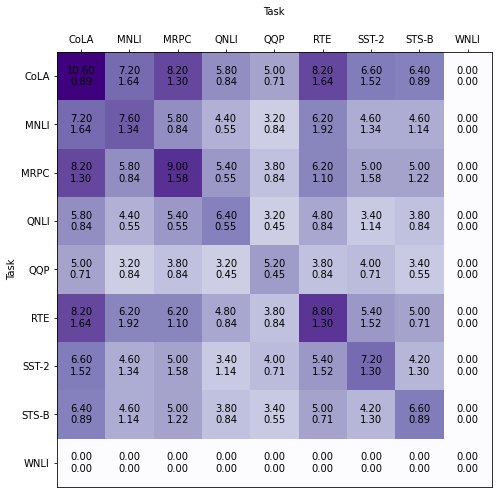

In [7]:

task_overlap_mlps(mlp_data, "common_components/task_v_task_mlps_separate.pdf")

## Task vs Task shared MLPs - MLPS found together with Heads

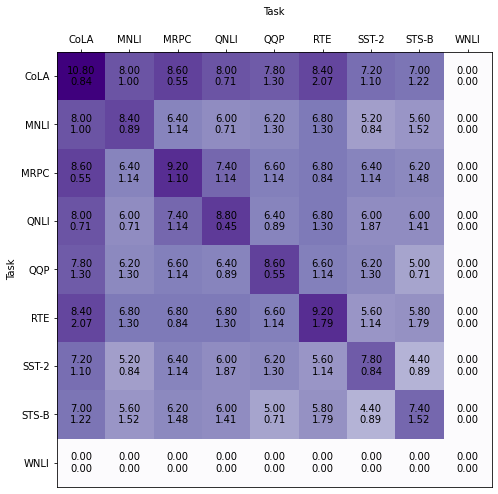

In [8]:

task_overlap_mlps(n_mlp_data, "common_components/task_v_task_mlps_together.pdf")